# Regression problem with keras

This notebooks contains a regression problem that is solved using a simple neural network, using the keras library. 

In this notebook we are going to deep dive into the following concepts:

- **Data preparation**: we are going to see feature-wise normalization
- **Network architecture**: due to the dimension of the dataset, we are going to use a smaller network. Loss function, metric and activation function for the last layer will be MSE, MAE and no activation function (since we don't have to restrict our inputs in any range)
- **Overfitting**: we are going to see how to tune hyperparameters using a k-fold cross validation approach


In [1]:
from keras.datasets import boston_housing
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

## 1. Data loading

We load the boston house pricing dataset from the keras libary.

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [3]:
print(f"train_data SHAPE: {train_data.shape}")
print(f"train_targets SHAPE: {train_targets.shape}")
print(f"test_data SHAPE: {test_data.shape}")
print(f"test_targets SHAPE: {test_targets.shape}")

train_data SHAPE: (404, 13)
train_targets SHAPE: (404,)
test_data SHAPE: (102, 13)
test_targets SHAPE: (102,)


In [4]:
print(f"These are the median values of the houses (in thousand of dollars):\n {train_targets[0:15]}..")

These are the median values of the houses (in thousand of dollars):
 [15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7]..


In [5]:
print(f"One row (one sample) has n {train_data[0].shape} features")

One row (one sample) has n (13,) features


## 2. Data preparation

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. 

A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

**Note: the quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.**

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [7]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

## 3. Bulding the network

Here we need to design the network, in term of number of layers, number of hidden units per layer, loss function and metrics to monitor.

**Mid layers**:
There a few samples are available, so we'll use a very small network with two hidden layers, each with 64 units. *In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.*


**Output layer**:
The network ends with a single unit and no activation. This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a sigmoid activation function to the last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

**Loss function and metrics**:
We are going to use the mse loss function (mean squared error): the square of the difference between the predictions and the targets.
We are monitoring during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500
on average.

In [8]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

## 4. Model evaluation

To evaluate the network while you keep adjusting its (hyper-)parameters (such as the number of epochs used for training), we are going to use a K-fold cross-validation approach.

It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.

In [9]:
k=4 # 4-fold cross validation
num_val_samples = len(train_data) // k # len(train_data) = 404, num_val_samples = 101
num_epochs = 100
all_scores = []

for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    print(f"val_data SHAPE: {val_data.shape}")
    print(f"val_targets SHAPE: {val_targets.shape}")
    print(f"partial_train_data SHAPE: {partial_train_data.shape}")
    print(f"partial_train_targets SHAPE: {partial_train_targets.shape}")
    print("--------------------------------------------")
    

processing fold # 0
val_data SHAPE: (101, 13)
val_targets SHAPE: (101,)
partial_train_data SHAPE: (303, 13)
partial_train_targets SHAPE: (303,)
--------------------------------------------
processing fold # 1
val_data SHAPE: (101, 13)
val_targets SHAPE: (101,)
partial_train_data SHAPE: (303, 13)
partial_train_targets SHAPE: (303,)
--------------------------------------------
processing fold # 2
val_data SHAPE: (101, 13)
val_targets SHAPE: (101,)
partial_train_data SHAPE: (303, 13)
partial_train_targets SHAPE: (303,)
--------------------------------------------
processing fold # 3
val_data SHAPE: (101, 13)
val_targets SHAPE: (101,)
partial_train_data SHAPE: (303, 13)
partial_train_targets SHAPE: (303,)
--------------------------------------------


In [10]:
for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [12]:
print(f"Validation MAE scores for the 4 training processes: {all_scores}\n")
print(f"Validation MAE average: {np.average(all_scores)}")


Validation MAE scores for the 4 training processes: [2.1407392024993896, 2.5022964477539062, 2.6515953540802, 2.5531888008117676]

Validation MAE average: 2.461954951286316


## 4a. How to tune hyperparameters with k-fold cross validation

There are some important things to discuss here.

The 1st for loop just shows how a 4-fold cross validation deals with training and validation data 

The 2nd for loop is the actual 4-fold cross validation that build and train 4 models. The 4 models have been trained 
with the same hyperparameters and the validation MAE for the 4 iterations have been stored in the `all_scores` array. 

If we average the MAE in `all_scores` we get a much more reliable meausre than if we were to just train a single model and evaluate it once. 

However, k-fold cross validation can do much more than simply storing a metric value at each iteration. Let's say we want to observe how the MAE change with different number of epochs in order to choose the best value for the epochs hyperparameter. What we can do is the following:

1. We modify the k-fold cross validation loop and we store the MAE score per-epoch 
2. We compute the average of the per-epoch MAE scores for all folds
3. We plot the results in a chart with x, y axis as `epochs`, `Validation MAE` obtaining a validation MAE by epoch

In the plot we will see that the model starts overfitting after a certain number of epochs and so we are going to be able to select the best number of epochs. 

We can apply the same logic to other hyperparameter of the NN: number of layers, number of hidden units, etc. 

This is how **hyperparameters tuning** works with k-fold cross validation. 

Once we find the best hyperparameters, we train our model on the full training + validation set and we measure its statistical power against the test set. 

In [17]:
k=4 # 4-fold cross validation
num_val_samples = len(train_data) // k # len(train_data) = 404, num_val_samples = 101
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    
    # here is how we store per-epoch MAE
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [22]:
print(f"MAE histories containing: {len(all_mae_histories)} training rounds")
print(f"Each training round containing: {len(all_mae_histories[0])} MAE == number of epochs")

MAE histories containing: 4 training rounds
Each training round containing: 500 MAE == number of epochs


Now we want to compute the average of the per-epoch MAE scores for all folds. This answers the question: *what's the average MAE score at epoch i?* 

In [23]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [28]:
print(f"We have obtained an average MAE, the lenght of average_mae_history is indeed: {len(average_mae_history)}")

We have obtained an average MAE, the lenght of average_mae_history is indeed: 500


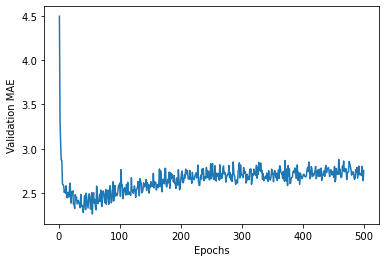

In [29]:
plt.plot(range(1, len(average_mae_history) +1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

The chart shows high variance and it's hard to undersand where the overfitting stars happening. We can try to smooth the curve to get a clearer understanding.

We will see in the chart below, that MAE starts increasing after epoch 80. So we can train a new model with 80 as optimal epoch hyperparameter. 

In [30]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

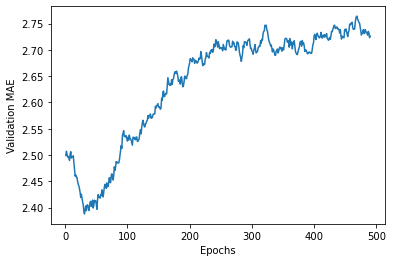

In [31]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

## 5. Model retraining with 80 epochs

In [67]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=1, verbose=1)


Epoch 1/80
404/404 [==============================] - 0s 848us/step - loss: 166.1077 - mae: 9.2364
Epoch 2/80
404/404 [==============================] - 0s 893us/step - loss: 21.9098 - mae: 3.1356
Epoch 3/80
404/404 [==============================] - 0s 862us/step - loss: 16.8608 - mae: 2.7706
Epoch 4/80
404/404 [==============================] - 0s 851us/step - loss: 14.6129 - mae: 2.5952
Epoch 5/80
404/404 [==============================] - 0s 839us/step - loss: 12.6857 - mae: 2.4684
Epoch 6/80
404/404 [==============================] - 0s 839us/step - loss: 11.8135 - mae: 2.4214
Epoch 7/80
404/404 [==============================] - 0s 838us/step - loss: 10.9567 - mae: 2.2786
Epoch 8/80
404/404 [==============================] - 0s 839us/step - loss: 10.8067 - mae: 2.2963
Epoch 9/80
404/404 [==============================] - 0s 823us/step - loss: 10.7090 - mae: 2.2039
Epoch 10/80
404/404 [==============================] - 0s 846us/step - loss: 10.3338 - mae: 2.2135
Epoch 11/80
404/40

In [69]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(f"Test MSE Score {test_mse_score}, Test MAE Score {test_mae_score}")

4/4 [==============================] - 0s 2ms/step - loss: 15.8104 - mae: 2.3135
Test MSE Score 15.81042766571045, Test MAE Score 2.3134732246398926


Looking at our MAE score on the test set, we can conclude that we are still off about $2.300 